In [2]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
wireplane = "V"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
    #    for k in range(nticks):
    #        waveforms.append(data[string+str(k)].astype(np.int16))
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [5]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "../../dunesnb/1dcnn/train/train/nu_cc/"
path2 = "../../dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "../../dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])

# Train/Noise Data Preprocessing



In [6]:
from sklearn.utils import shuffle
print("Unfiltered:" + str(combined_data.shape[0]))
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print("> ADC_MIN:" + str(combined_data.shape[0]))

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print("Train Split:" + str(combined_data.shape[0]))
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print("Train Split Filtered ADC_MIN < x < ADC_MAX:" + str(combined_data.shape[0]))
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)
#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print("Test Set:" + str(test_signal_waveforms.shape[0]))

Unfiltered:231744
> ADC_MIN:130731
Train Split:65365
Train Split Filtered ADC_MIN < x < ADC_MAX:62239
Test Set:65366


In [7]:
print(test_signal_waveforms.shape, signal_waveforms.shape, noise_waveforms.shape)

(65366, 200) (62239, 200) (108600, 200)


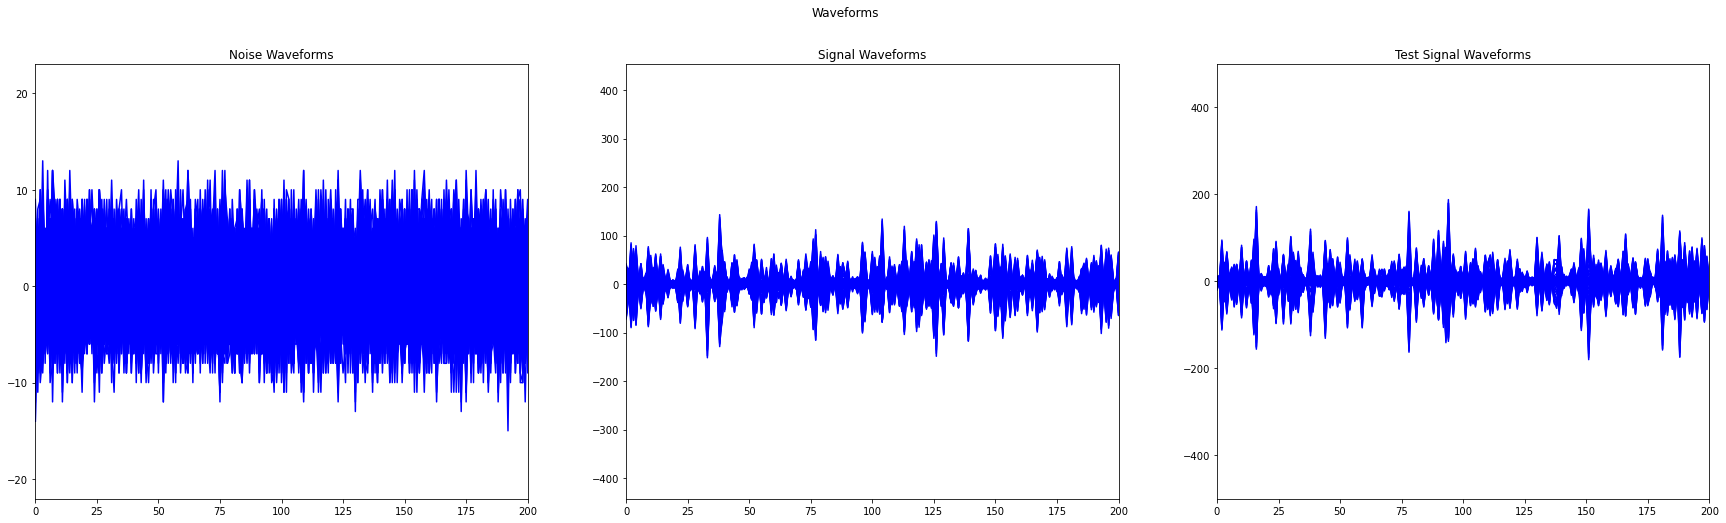

In [8]:
start_for_plot = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('Waveforms')
ax1.plot(noise_waveforms,color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms,color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("Signal Waveforms")

ax3.plot(test_signal_waveforms,color='blue')
ax3.set_xlim(start_for_plot, start_for_plot + 200)
ax3.set_title("Test Signal Waveforms")
ax3.set_ybound(-500, 500)
plt.show()

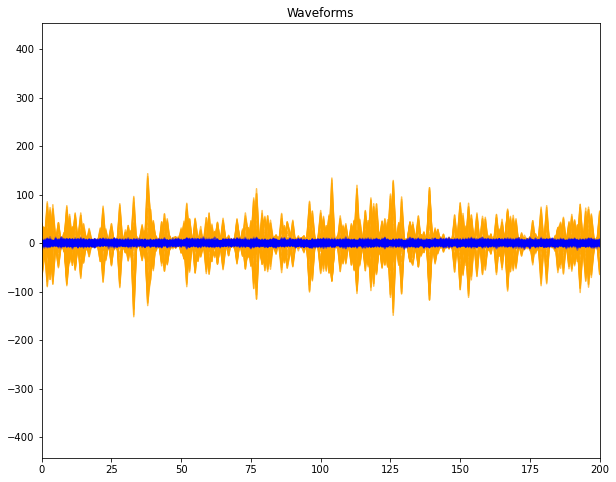

In [9]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(signal_waveforms,color='orange', alpha=0.7)
plt.plot(noise_waveforms,color='blue',alpha=0.3)
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("Waveforms")
plt.show()

In [10]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])

# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, y_noise_full, test_size=0.5, shuffle=True)
#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)
#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

In [11]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(54300, 200) (62239, 200) (65366, 200)


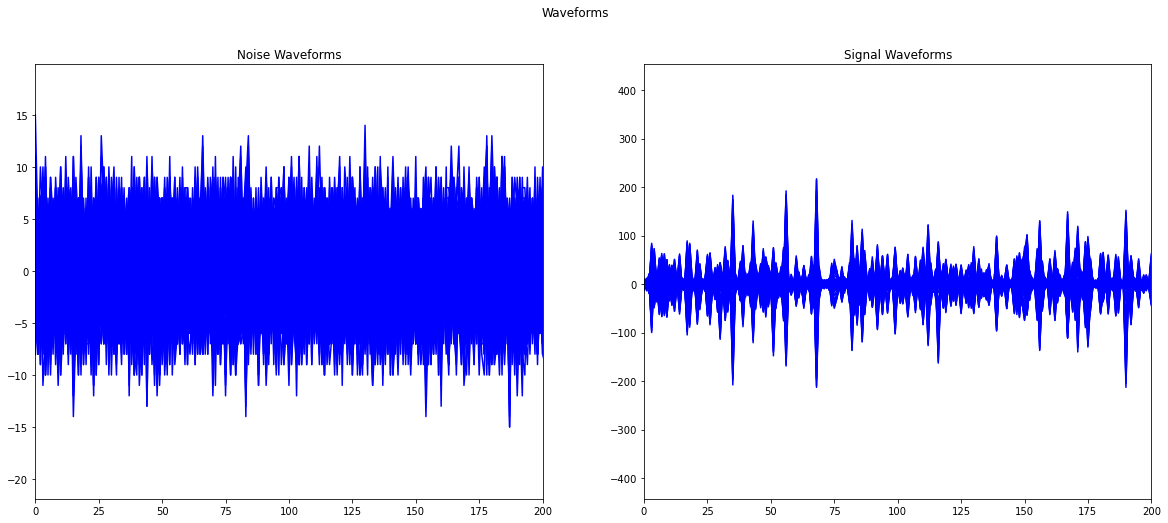

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(x_noise_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("Signal Waveforms")
plt.show()

In [13]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))
x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)
#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape)

(86880, 200) (86880,) (108600, 200) (108600,) (21720, 200) (21720,)


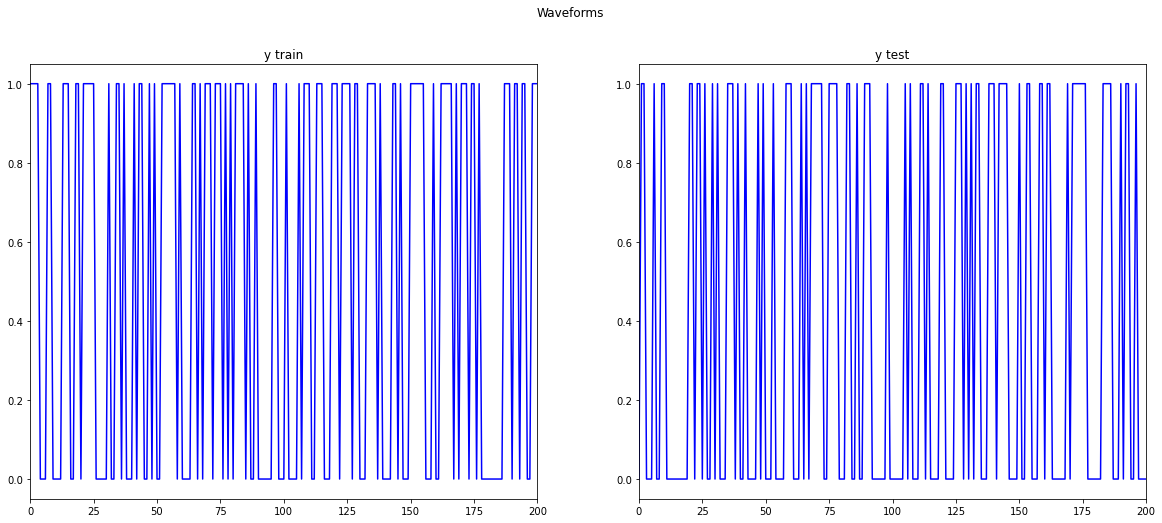

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(y_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("y train")

ax2.plot(y_test, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("y test")
plt.show()

In [16]:
mean = x_train.mean()
std = x_train.std()

In [17]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 

In [18]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(86880, 200) (21720, 200) (108600, 200)


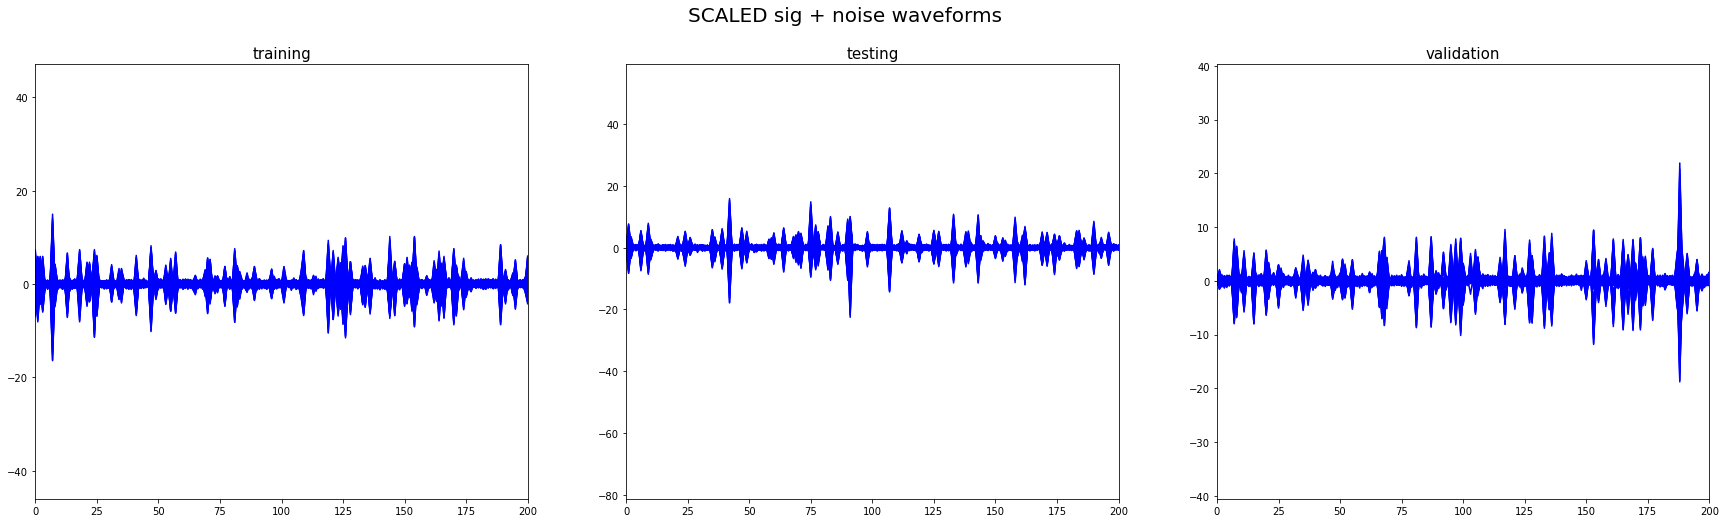

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('SCALED sig + noise waveforms',fontsize=20)
ax1.plot(x_train_scaled, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("training", fontsize=15)

ax2.plot(x_test_scaled, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("testing", fontsize=15)

ax3.plot(x_valid_scaled, color='blue')
ax3.set_xlim(0, 200)
ax3.set_title("validation", fontsize=15)
plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
#from keras import backend as K

In [21]:
x_train_scaled[0].shape

(200,)

In [22]:
for i in range(0,10):
    print(x_train_scaled[i].shape)

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)


In [23]:
x_train_scaled.shape

(86880, 200)

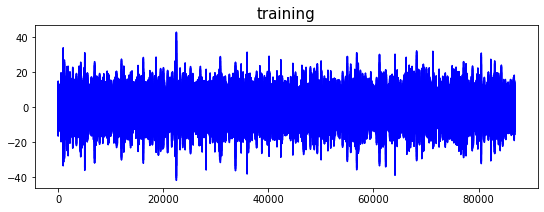

In [24]:
plt.figure(figsize=(9, 3))
plt.plot(x_train_scaled, color='blue')
#plt.xlim(0, 200)
plt.title("training", fontsize=15)
plt.show()

# Autoencoder

In [25]:
from tensorflow.keras.models import load_model
model = load_model("learn_models/Vplane_nu.h5")

In [26]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 conv1d
1 max_pooling1d
2 conv1d_1
3 max_pooling1d_1
4 dropout
5 conv1d_2
6 global_max_pooling1d
7 dropout_1
8 flatten
9 wavrec_out


In [27]:
time_periods = 1000

In [28]:
"""
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
#second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)
x = MaxPooling1D(pool_size=2)(x)

encoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(6)(x)

x = Conv1D(filters=64, kernel_size=8, padding = "same", activation = "relu")(x)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=7,  activation = "relu")(x)
x = UpSampling1D(4)(x)
x = Conv1D(filters=16, kernel_size=7,   activation = "relu")(x)
x = UpSampling1D(4)(x)
x = Conv1D(filters=8, kernel_size=8,   activation = "relu")(x)
x = UpSampling1D(4)(x)

decoded = Conv1D(filters=1, kernel_size=9,  activation = "linear")(x)



autoencoder = Model(input_wave, decoded)

"""



'\ninput_wave = Input(shape=(x_train_scaled.shape[1], 1)) \nx = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)\nx = MaxPooling1D(pool_size=2)(x)\n \n#second convolutional block\nx = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)\nx = MaxPooling1D(pool_size=2)(x)\n\nencoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)\n\n\nx = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)\nx = UpSampling1D(6)(x)\n\nx = Conv1D(filters=64, kernel_size=8, padding = "same", activation = "relu")(x)\nx = UpSampling1D(4)(x)\n\nx = Conv1D(filters=32, kernel_size=7,  activation = "relu")(x)\nx = UpSampling1D(4)(x)\nx = Conv1D(filters=16, kernel_size=7,   activation = "relu")(x)\nx = UpSampling1D(4)(x)\nx = Conv1D(filters=8, kernel_size=8,   activation = "relu")(x

In [49]:
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
#second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)
x = MaxPooling1D(pool_size=2)(x)

encoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=5, padding = "same", activation = "relu")(x)
x = UpSampling1D(3)(x)

x = Conv1D(filters=16, kernel_size=3,  activation = "relu")(x)
x = UpSampling1D(6)(x)

decoded = Conv1D(filters=1, kernel_size=5,  activation = "linear")(x)



autoencoder = Model(input_wave, decoded)



In [50]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)   

0 input_6
1 conv1d_35
2 max_pooling1d_10
3 conv1d_36
4 max_pooling1d_11
5 conv1d_37
6 conv1d_38
7 up_sampling1d_15
8 conv1d_39
9 up_sampling1d_16
10 conv1d_40
11 up_sampling1d_17
12 conv1d_41


In [51]:
for layer in autoencoder.layers[:6]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[6:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

In [52]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_35 (Conv1D)          (None, 99, 16)            64        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 49, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 23, 32)            2592      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 3, 64)             1849

In [33]:
x_train_scaled.shape

(86880, 200)

In [53]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
                    x_train_scaled,                                                            
                    batch_size=256,                                              
                    epochs=80,                                                      
                    callbacks=None, # callbacks=callbacks_list,                         
                    validation_split=0.2,                                               
                    verbose=1)   

Epoch 1/80
272/272 [==============================] - 8s 7ms/step - loss: 0.5237 - val_loss: 0.3294
Epoch 2/80
272/272 [==============================] - 2s 6ms/step - loss: 0.2914 - val_loss: 0.2750
Epoch 3/80
272/272 [==============================] - 2s 6ms/step - loss: 0.2486 - val_loss: 0.2418
Epoch 4/80
272/272 [==============================] - 2s 6ms/step - loss: 0.2245 - val_loss: 0.2182
Epoch 5/80
272/272 [==============================] - 2s 6ms/step - loss: 0.2114 - val_loss: 0.2110
Epoch 6/80
272/272 [==============================] - 2s 6ms/step - loss: 0.2021 - val_loss: 0.2035
Epoch 7/80
272/272 [==============================] - 2s 6ms/step - loss: 0.1972 - val_loss: 0.1945
Epoch 8/80
272/272 [==============================] - 2s 6ms/step - loss: 0.1900 - val_loss: 0.1930
Epoch 9/80
272/272 [==============================] - 2s 6ms/step - loss: 0.1875 - val_loss: 0.1866
Epoch 10/80
272/272 [==============================] - 2s 6ms/step - loss: 0.1804 - val_loss: 0.1818

In [54]:
%%time
y = autoencoder.predict(x_test_scaled, batch_size=1024)

107/107 [==============================] - 1s 3ms/step
Wall time: 896 ms


In [55]:
y = y.reshape(y.shape[0], y.shape[1])

(0.0, 200.0)

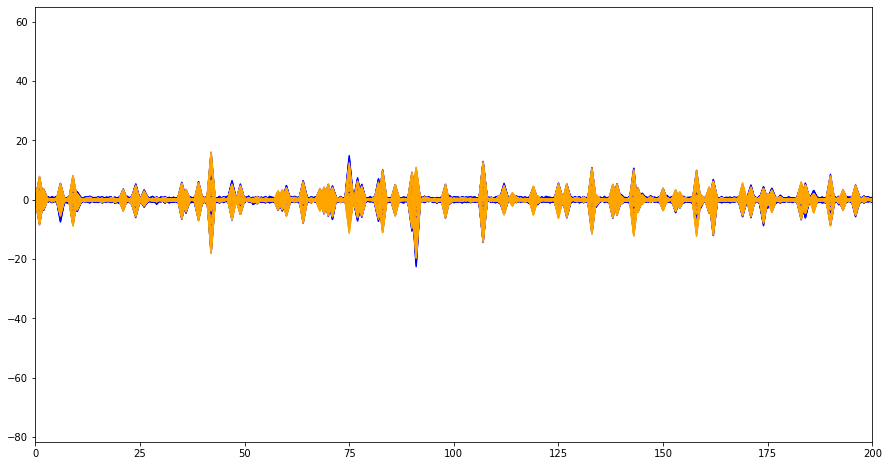

In [56]:
y = y.reshape(y.shape[0], y.shape[1])
idx =11
plt.figure(figsize=(15,8))
plt.plot(x_test_scaled,color='blue')
plt.plot(y,color='orange')
plt.xlim(0, 200)


In [58]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


In [59]:
%%time
%matplotlib inline
import seaborn as sns
infer = autoencoder.predict(x_train_, batch_size=4096)
infer = infer.reshape(infer.shape[0], infer.shape[1])

22/22 [==============================] - 0s 16ms/step
Wall time: 566 ms


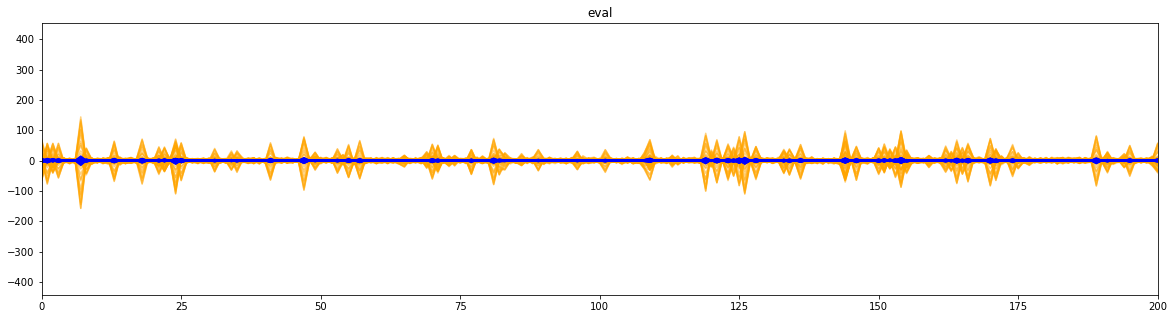

In [60]:
start_for_plot = 0
fig = plt.figure(figsize=(20, 5))
plt.plot(x_train,color='orange',alpha=0.5)
plt.plot(infer,color='blue',alpha=0.7)
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("eval")
plt.show()

In [61]:
%%time
y = autoencoder.predict(x_test_scaled, batch_size=1024)

107/107 [==============================] - 0s 4ms/step
Wall time: 639 ms


(0.0, 200.0)

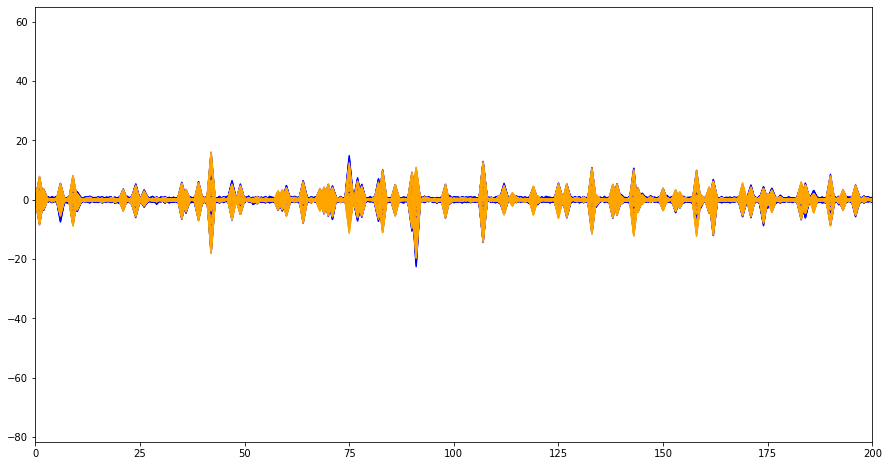

In [62]:
y = y.reshape(y.shape[0], y.shape[1])
idx =11
plt.figure(figsize=(15,8))
plt.plot(x_test_scaled,color='blue')
plt.plot(y,color='orange')
plt.xlim(0, 200)
